In [19]:
import flwr as fl
import tensorflow as tf
from tensorflow import keras
from keras import layers
import utils as ut
from typing import Dict, Optional, Tuple
from pathlib import Path
import numpy as np
import matplotlib.pyplot  as plt

In [2]:

def get_evaluate_fn(model, x_test, y_test):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every round
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:

        # Update the model with the latest parameters
        model.set_weights(parameters)

        # Evaluate the model on the test data
        predictions = model.predict(x_test)
        loss = tf.keras.losses.mean_squared_error(y_test, predictions).numpy().mean().item()
        mae = tf.keras.metrics.mean_absolute_error(y_test, predictions).numpy().mean().item()

        return loss, {"mae": mae}

    return evaluate

def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Keep batch size fixed at 32, perform two rounds of training with one local epoch,
    increase to two local epochs afterwards.
    """
    config = {
        "batch_size": 128,
        "local_epochs": 50 if server_round < 2 else 100,
    }
    return config


def evaluate_config(server_round: int):
    """Return evaluation configuration dict for each round.

    Perform five local evaluation steps on each client (i.e., use five batches) during
    rounds one to three, then increase to ten local evaluation steps.
    """
    val_steps = 5 if server_round < 4 else 10
    return {"val_steps": val_steps}

In [3]:
(x_train, y_train), (x_test, y_test) = ut.partition_dataset(2,3,1)

model = tf.keras.models.Sequential(
    [
        layers.Input(shape=(8,)),  
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),  
        layers.Dense(1)  
    ]
)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.75,
    fraction_evaluate=1,
    min_fit_clients=3,
    min_evaluate_clients=4,
    min_available_clients=4,
    evaluate_fn=get_evaluate_fn(model,x_test,y_test),
    on_fit_config_fn=fit_config,
    on_evaluate_config_fn=evaluate_config,
    initial_parameters=fl.common.ndarrays_to_parameters(model.get_weights()),
)




In [4]:
# Start Flower server
history_with_noise = fl.server.start_server(
    server_address="127.0.0.1:8080",
    config=fl.server.ServerConfig(num_rounds=10),
    strategy = strategy
)

INFO flwr 2023-11-23 01:50:57,866 | app.py:162 | Starting Flower server, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2023-11-23 01:50:57,905 | app.py:175 | Flower ECE: gRPC server running (10 rounds), SSL is disabled
INFO flwr 2023-11-23 01:50:57,905 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-23 01:50:57,906 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-11-23 01:50:57,906 | server.py:91 | Evaluating initial parameters


129/129 [==============================] - 0s 841us/step


INFO flwr 2023-11-23 01:50:58,285 | server.py:94 | initial parameters (loss, other metrics): 5.775308132171631, {'mae': 2.1126232147216797}
INFO flwr 2023-11-23 01:50:58,286 | server.py:104 | FL starting
DEBUG flwr 2023-11-23 01:51:37,756 | server.py:222 | fit_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:51:43,640 | server.py:236 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-11-23 01:51:43,643 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


129/129 [==============================] - 0s 937us/step


INFO flwr 2023-11-23 01:51:43,921 | server.py:125 | fit progress: (1, 2.1078832149505615, {'mae': 1.1092127561569214}, 45.63434220000636)
DEBUG flwr 2023-11-23 01:51:43,922 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:51:44,771 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-11-23 01:51:44,773 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-23 01:51:44,773 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:51:55,186 | server.py:236 | fit_round 2 received 3 results and 0 failures


129/129 [==============================] - 0s 930us/step


INFO flwr 2023-11-23 01:51:55,451 | server.py:125 | fit progress: (2, 2.2441775798797607, {'mae': 1.1574554443359375}, 57.16477249999298)
DEBUG flwr 2023-11-23 01:51:55,452 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:51:56,261 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:51:56,262 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:07,489 | server.py:236 | fit_round 3 received 3 results and 0 failures


129/129 [==============================] - 0s 867us/step


INFO flwr 2023-11-23 01:52:07,750 | server.py:125 | fit progress: (3, 2.2393100261688232, {'mae': 1.1542896032333374}, 69.46343539998634)
DEBUG flwr 2023-11-23 01:52:07,751 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:08,659 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:52:08,661 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:19,803 | server.py:236 | fit_round 4 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:52:20,109 | server.py:125 | fit progress: (4, 2.2252376079559326, {'mae': 1.1530669927597046}, 81.8220439000288)
DEBUG flwr 2023-11-23 01:52:20,110 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:21,146 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:52:21,148 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:33,088 | server.py:236 | fit_round 5 received 3 results and 0 failures


129/129 [==============================] - 0s 891us/step


INFO flwr 2023-11-23 01:52:33,359 | server.py:125 | fit progress: (5, 2.316370964050293, {'mae': 1.182008981704712}, 95.07207970001036)
DEBUG flwr 2023-11-23 01:52:33,360 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:34,622 | server.py:187 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:52:34,624 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:46,559 | server.py:236 | fit_round 6 received 3 results and 0 failures


129/129 [==============================] - 0s 2ms/step


INFO flwr 2023-11-23 01:52:46,959 | server.py:125 | fit progress: (6, 2.394761323928833, {'mae': 1.2072343826293945}, 108.67327870003646)
DEBUG flwr 2023-11-23 01:52:46,960 | server.py:173 | evaluate_round 6: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:52:47,877 | server.py:187 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:52:47,878 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:00,731 | server.py:236 | fit_round 7 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:53:01,034 | server.py:125 | fit progress: (7, 2.284499168395996, {'mae': 1.1726267337799072}, 122.74719120003283)
DEBUG flwr 2023-11-23 01:53:01,034 | server.py:173 | evaluate_round 7: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:01,984 | server.py:187 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:53:01,985 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:15,107 | server.py:236 | fit_round 8 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:53:15,425 | server.py:125 | fit progress: (8, 2.3939924240112305, {'mae': 1.2009563446044922}, 137.1391534000286)
DEBUG flwr 2023-11-23 01:53:15,426 | server.py:173 | evaluate_round 8: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:16,439 | server.py:187 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:53:16,441 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:30,222 | server.py:236 | fit_round 9 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:53:30,550 | server.py:125 | fit progress: (9, 2.3399317264556885, {'mae': 1.185317039489746}, 152.26293730002362)
DEBUG flwr 2023-11-23 01:53:30,551 | server.py:173 | evaluate_round 9: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:31,645 | server.py:187 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:53:31,646 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:45,107 | server.py:236 | fit_round 10 received 3 results and 0 failures


129/129 [==============================] - 0s 991us/step


INFO flwr 2023-11-23 01:53:45,408 | server.py:125 | fit progress: (10, 2.357820749282837, {'mae': 1.1831157207489014}, 167.12189000000944)
DEBUG flwr 2023-11-23 01:53:45,409 | server.py:173 | evaluate_round 10: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:53:46,374 | server.py:187 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-11-23 01:53:46,375 | server.py:153 | FL finished in 168.0886041999911
INFO flwr 2023-11-23 01:53:46,376 | app.py:225 | app_fit: losses_distributed [(1, 2.127435028553009), (2, 2.389154374599457), (3, 2.4064800143241882), (4, 2.4260382652282715), (5, 2.7680426836013794), (6, 2.566336512565613), (7, 2.4655032753944397), (8, 2.995591878890991), (9, 2.5242376923561096), (10, 2.6346829533576965)]
INFO flwr 2023-11-23 01:53:46,377 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-23 01:53:46,377 | app.py:227 | app_fit: metrics_distributed {}
INFO flwr 2023-11-23 01:53:46,377 | app.py:228 | app_fit: losses_centr

In [5]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.75,
    fraction_evaluate=1,
    min_fit_clients=3,
    min_evaluate_clients=4,
    min_available_clients=4,
    evaluate_fn=get_evaluate_fn(model,x_test,y_test),
    on_fit_config_fn=fit_config,
    on_evaluate_config_fn=evaluate_config,
    initial_parameters=fl.common.ndarrays_to_parameters(model.get_weights()),
)

history_without_noise = fl.server.start_server(
    server_address="127.0.0.1:8081",
    config=fl.server.ServerConfig(num_rounds=10),
    strategy = strategy
)

INFO flwr 2023-11-23 01:54:42,018 | app.py:162 | Starting Flower server, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2023-11-23 01:54:42,048 | app.py:175 | Flower ECE: gRPC server running (10 rounds), SSL is disabled
INFO flwr 2023-11-23 01:54:42,049 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-23 01:54:42,050 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-11-23 01:54:42,050 | server.py:91 | Evaluating initial parameters


129/129 [==============================] - 0s 875us/step


INFO flwr 2023-11-23 01:54:42,304 | server.py:94 | initial parameters (loss, other metrics): 2.357820749282837, {'mae': 1.1831157207489014}
INFO flwr 2023-11-23 01:54:42,305 | server.py:104 | FL starting
DEBUG flwr 2023-11-23 01:55:11,201 | server.py:222 | fit_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:17,412 | server.py:236 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-11-23 01:55:17,414 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


129/129 [==============================] - 0s 852us/step


INFO flwr 2023-11-23 01:55:17,663 | server.py:125 | fit progress: (1, 2.3590497970581055, {'mae': 1.1687849760055542}, 35.35774289997062)
DEBUG flwr 2023-11-23 01:55:17,664 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:18,534 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-11-23 01:55:18,535 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-23 01:55:18,536 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:29,463 | server.py:236 | fit_round 2 received 3 results and 0 failures


129/129 [==============================] - 0s 836us/step


INFO flwr 2023-11-23 01:55:29,715 | server.py:125 | fit progress: (2, 2.383659839630127, {'mae': 1.1718279123306274}, 47.409480899979826)
DEBUG flwr 2023-11-23 01:55:29,716 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:30,609 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:55:30,610 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:42,907 | server.py:236 | fit_round 3 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:55:43,238 | server.py:125 | fit progress: (3, 2.3965518474578857, {'mae': 1.1755235195159912}, 60.93260000000009)
DEBUG flwr 2023-11-23 01:55:43,239 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:44,117 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:55:44,118 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:55,452 | server.py:236 | fit_round 4 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:55:55,745 | server.py:125 | fit progress: (4, 2.351491928100586, {'mae': 1.159561276435852}, 73.43909759999951)
DEBUG flwr 2023-11-23 01:55:55,745 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:55:56,608 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:55:56,610 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:08,297 | server.py:236 | fit_round 5 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:56:08,583 | server.py:125 | fit progress: (5, 2.3668923377990723, {'mae': 1.1653813123703003}, 86.27688570000464)
DEBUG flwr 2023-11-23 01:56:08,583 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:09,450 | server.py:187 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:56:09,451 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:21,482 | server.py:236 | fit_round 6 received 3 results and 0 failures


129/129 [==============================] - 0s 945us/step


INFO flwr 2023-11-23 01:56:21,755 | server.py:125 | fit progress: (6, 2.3402113914489746, {'mae': 1.1562747955322266}, 99.44895709998673)
DEBUG flwr 2023-11-23 01:56:21,755 | server.py:173 | evaluate_round 6: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:22,868 | server.py:187 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:56:22,869 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:35,094 | server.py:236 | fit_round 7 received 3 results and 0 failures


129/129 [==============================] - 0s 992us/step


INFO flwr 2023-11-23 01:56:35,385 | server.py:125 | fit progress: (7, 2.3295609951019287, {'mae': 1.1554046869277954}, 113.07917189999716)
DEBUG flwr 2023-11-23 01:56:35,386 | server.py:173 | evaluate_round 7: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:36,327 | server.py:187 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:56:36,329 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:48,641 | server.py:236 | fit_round 8 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:56:48,958 | server.py:125 | fit progress: (8, 2.445713520050049, {'mae': 1.188620924949646}, 126.65209210000467)
DEBUG flwr 2023-11-23 01:56:48,959 | server.py:173 | evaluate_round 8: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:56:49,909 | server.py:187 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:56:49,910 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:57:02,120 | server.py:236 | fit_round 9 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:57:02,420 | server.py:125 | fit progress: (9, 2.4645471572875977, {'mae': 1.191007375717163}, 140.1144841000205)
DEBUG flwr 2023-11-23 01:57:02,421 | server.py:173 | evaluate_round 9: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:57:03,384 | server.py:187 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-11-23 01:57:03,386 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 01:57:15,416 | server.py:236 | fit_round 10 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 01:57:15,732 | server.py:125 | fit progress: (10, 2.377683639526367, {'mae': 1.1676628589630127}, 153.42621270002564)
DEBUG flwr 2023-11-23 01:57:15,733 | server.py:173 | evaluate_round 10: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 01:57:16,650 | server.py:187 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-11-23 01:57:16,651 | server.py:153 | FL finished in 154.34498789999634
INFO flwr 2023-11-23 01:57:16,651 | app.py:225 | app_fit: losses_distributed [(1, 2.2793779373168945), (2, 2.3680520057678223), (3, 2.3373703956604004), (4, 2.2790939807891846), (5, 2.282250165939331), (6, 2.2932262420654297), (7, 2.2717788219451904), (8, 2.399872064590454), (9, 2.4535892009735107), (10, 2.3278539180755615)]
INFO flwr 2023-11-23 01:57:16,652 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-23 01:57:16,652 | app.py:227 | app_fit: metrics_distributed {}
INFO flwr 2023-11-23 01:57:16,652 | app.py:228 | app_fit: losses_ce

In [6]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.75,
    fraction_evaluate=1,
    min_fit_clients=3,
    min_evaluate_clients=4,
    min_available_clients=4,
    evaluate_fn=get_evaluate_fn(model,x_test,y_test),
    on_fit_config_fn=fit_config,
    on_evaluate_config_fn=evaluate_config,
    initial_parameters=fl.common.ndarrays_to_parameters(model.get_weights()),
)

history_with_minus_noise = fl.server.start_server(
    server_address="127.0.0.1:8082",
    config=fl.server.ServerConfig(num_rounds=10),
    strategy = strategy
)

INFO flwr 2023-11-23 01:59:42,216 | app.py:162 | Starting Flower server, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2023-11-23 01:59:42,234 | app.py:175 | Flower ECE: gRPC server running (10 rounds), SSL is disabled
INFO flwr 2023-11-23 01:59:42,234 | server.py:89 | Initializing global parameters
INFO flwr 2023-11-23 01:59:42,235 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-11-23 01:59:42,235 | server.py:91 | Evaluating initial parameters


129/129 [==============================] - 0s 953us/step


INFO flwr 2023-11-23 01:59:42,508 | server.py:94 | initial parameters (loss, other metrics): 2.377683639526367, {'mae': 1.1676628589630127}
INFO flwr 2023-11-23 01:59:42,509 | server.py:104 | FL starting
DEBUG flwr 2023-11-23 02:00:05,392 | server.py:222 | fit_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:11,341 | server.py:236 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-11-23 02:00:11,343 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


129/129 [==============================] - 0s 757us/step


INFO flwr 2023-11-23 02:00:11,575 | server.py:125 | fit progress: (1, 2.7696542739868164, {'mae': 1.2578725814819336}, 29.065098599996418)
DEBUG flwr 2023-11-23 02:00:11,576 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:12,497 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-11-23 02:00:12,498 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-23 02:00:12,499 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:22,674 | server.py:236 | fit_round 2 received 3 results and 0 failures


129/129 [==============================] - 0s 885us/step


INFO flwr 2023-11-23 02:00:22,932 | server.py:125 | fit progress: (2, 2.601820707321167, {'mae': 1.2130237817764282}, 40.422277899924666)
DEBUG flwr 2023-11-23 02:00:22,934 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:23,758 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:00:23,759 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:35,009 | server.py:236 | fit_round 3 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:00:35,305 | server.py:125 | fit progress: (3, 2.6631853580474854, {'mae': 1.2281280755996704}, 52.79474239994306)
DEBUG flwr 2023-11-23 02:00:35,306 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:36,275 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:00:36,276 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:47,869 | server.py:236 | fit_round 4 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:00:48,166 | server.py:125 | fit progress: (4, 2.564310312271118, {'mae': 1.203072428703308}, 65.65596010000445)
DEBUG flwr 2023-11-23 02:00:48,167 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:00:49,153 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:00:49,154 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:01,296 | server.py:236 | fit_round 5 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:01:01,595 | server.py:125 | fit progress: (5, 2.805962085723877, {'mae': 1.2664763927459717}, 79.08437359996606)
DEBUG flwr 2023-11-23 02:01:01,596 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:02,545 | server.py:187 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:01:02,546 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:15,152 | server.py:236 | fit_round 6 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:01:15,456 | server.py:125 | fit progress: (6, 3.0047056674957275, {'mae': 1.3130028247833252}, 92.94586649991106)
DEBUG flwr 2023-11-23 02:01:15,457 | server.py:173 | evaluate_round 6: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:16,613 | server.py:187 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:01:16,614 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:29,528 | server.py:236 | fit_round 7 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:01:29,850 | server.py:125 | fit progress: (7, 2.896428346633911, {'mae': 1.2810487747192383}, 107.33937249996234)
DEBUG flwr 2023-11-23 02:01:29,850 | server.py:173 | evaluate_round 7: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:30,804 | server.py:187 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:01:30,806 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:43,649 | server.py:236 | fit_round 8 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:01:43,977 | server.py:125 | fit progress: (8, 2.828364133834839, {'mae': 1.2622789144515991}, 121.46677659999114)
DEBUG flwr 2023-11-23 02:01:43,978 | server.py:173 | evaluate_round 8: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:44,977 | server.py:187 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:01:44,978 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:57,445 | server.py:236 | fit_round 9 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:01:57,819 | server.py:125 | fit progress: (9, 2.8816874027252197, {'mae': 1.2733802795410156}, 135.30840239999816)
DEBUG flwr 2023-11-23 02:01:57,819 | server.py:173 | evaluate_round 9: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:01:58,730 | server.py:187 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-11-23 02:01:58,731 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-11-23 02:02:11,211 | server.py:236 | fit_round 10 received 3 results and 0 failures


129/129 [==============================] - 0s 1ms/step


INFO flwr 2023-11-23 02:02:11,590 | server.py:125 | fit progress: (10, 2.8611953258514404, {'mae': 1.2631112337112427}, 149.07998789998237)
DEBUG flwr 2023-11-23 02:02:11,591 | server.py:173 | evaluate_round 10: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-11-23 02:02:12,499 | server.py:187 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-11-23 02:02:12,500 | server.py:153 | FL finished in 149.9902371999342
INFO flwr 2023-11-23 02:02:12,501 | app.py:225 | app_fit: losses_distributed [(1, 2.3105416297912598), (2, 2.3101747035980225), (3, 2.267969846725464), (4, 2.3874034881591797), (5, 2.3560914993286133), (6, 2.4283580780029297), (7, 2.404742479324341), (8, 2.398416757583618), (9, 2.399165391921997), (10, 2.4310128688812256)]
INFO flwr 2023-11-23 02:02:12,502 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-23 02:02:12,502 | app.py:227 | app_fit: metrics_distributed {}
INFO flwr 2023-11-23 02:02:12,503 | app.py:228 | app_fit: losses_cent

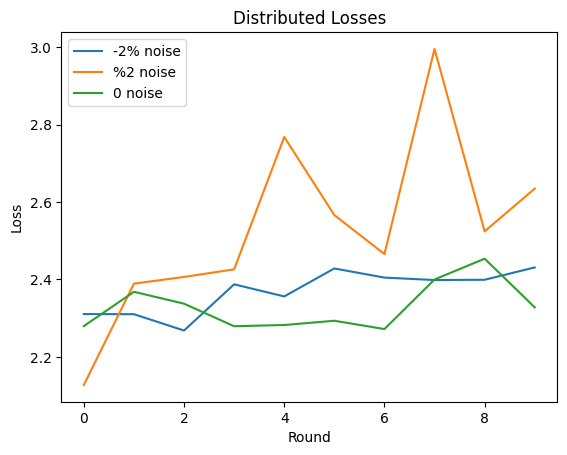

In [20]:
rounds = list(range(0, 10))
loss_distributed_hist1 = [history_with_minus_noise.losses_distributed[round_num][1] for round_num in rounds]
loss_distributed_hist2 = [history_with_noise.losses_distributed[round_num][1] for round_num in rounds]  
loss_distributed_hist3 = [history_without_noise.losses_distributed[round_num][1] for round_num in rounds]  

# Plot for distributed losses
plt.plot(rounds, loss_distributed_hist1, label='-2% noise')
plt.plot(rounds, loss_distributed_hist2, label='%2 noise')  
plt.plot(rounds, loss_distributed_hist3, label='0 noise')  

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Distributed Losses')
plt.legend()
plt.show()

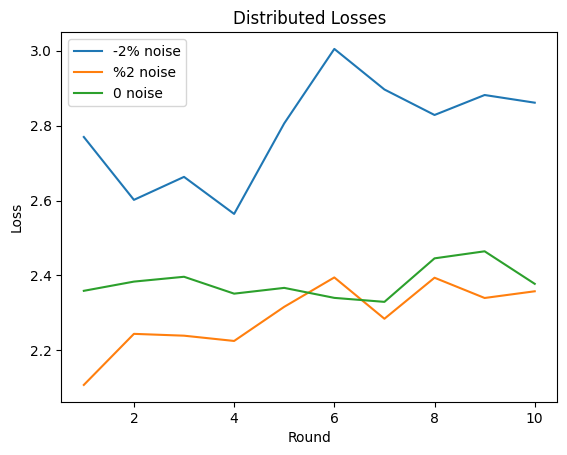

In [21]:
rounds = list(range(1, 11))
loss_distributed_hist1 = [history_with_minus_noise.losses_centralized[round_num][1] for round_num in rounds]
loss_distributed_hist2 = [history_with_noise.losses_centralized[round_num][1] for round_num in rounds]  
loss_distributed_hist3 = [history_without_noise.losses_centralized[round_num][1] for round_num in rounds]  

# Plot for distributed losses
plt.plot(rounds, loss_distributed_hist1, label='-2% noise')
plt.plot(rounds, loss_distributed_hist2, label='%2 noise')  
plt.plot(rounds, loss_distributed_hist3, label='0 noise')  

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Distributed Losses')
plt.legend()
plt.show()

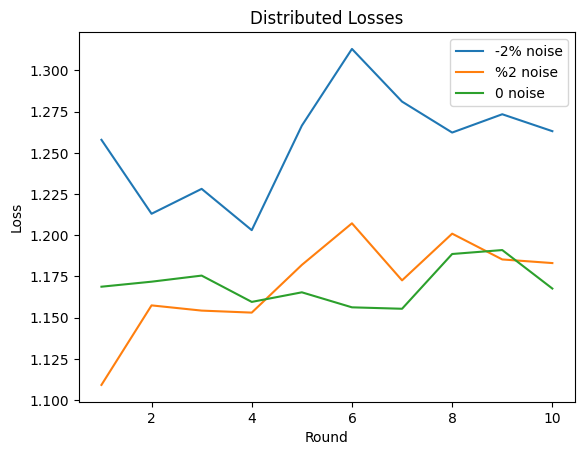

In [23]:
rounds = list(range(1, 11))
loss_distributed_hist1 = [history_with_minus_noise.metrics_centralized["mae"][round_num][1] for round_num in rounds]
loss_distributed_hist2 = [history_with_noise.metrics_centralized["mae"][round_num][1] for round_num in rounds]  
loss_distributed_hist3 = [history_without_noise.metrics_centralized["mae"][round_num][1] for round_num in rounds]  

# Plot for distributed losses
plt.plot(rounds, loss_distributed_hist1, label='-2% noise')
plt.plot(rounds, loss_distributed_hist2, label='%2 noise')  
plt.plot(rounds, loss_distributed_hist3, label='0 noise')  

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Distributed Losses')
plt.legend()
plt.show()